## Homework Assignment 9 - Version 2

In [ ]:
!pip install torch opencv-python ultralytics

In [ ]:
!pip install imageai face_recognition

In [ ]:
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import Video
from IPython.display import HTML
import matplotlib.pyplot as plt
from google.colab import drive
from ultralytics import YOLO
import imageio
import torch
import json
import cv2

In [ ]:
!mkdir /root/.kaggle/

api_token = {"username":"","key":""}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Question 1

**Question 1:** Select a short video with at least 3 animals and create a new movie from this video with a face tracker (each person’s face needs to be tracked by a rectangle of a different color) (50pt). See, for example, the video in: https://github.com/ageitgey/face_recognition

**Bonus:** Select a video with at least two people, and create a video with an people tracker (10pt).

#### Original Video

[Original Video](https://www.pexels.com/video/cute-little-brown-puppies-12768734/)

In [ ]:
input_video_path = "/content/drive/MyDrive/MiningMasiveData/pupies.mp4"
output_video_path = "/content/drive/MyDrive/MiningMasiveData/tracked.mp4"
model = YOLO("yolov5s.pt")

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



In [ ]:
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print(f"Error: Couldn't open video file {input_video_path}")
    exit()

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

print(f"Video dimensions: {frame_width}x{frame_height}")
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

try:
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
          print("End of video or error reading frame.")
          break

      results = model(frame)

      # Process detections
      for result in results:
          for box in result.boxes:  # Access boxes in each Results object
              x1, y1, x2, y2 = box.xyxy[0].tolist()
              conf = box.conf.item()
              cls = box.cls.item()
              label = model.names[int(cls)]
              confidence = f"{conf:.2f}"

              # Filter for animal classes (COCO classes)
              if label in ["dog", "cat", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "bird"]:
                  cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                  cv2.putText(frame, f"{label} {confidence}", (int(x1), int(y1) - 10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

      out.write(frame)
finally:
  cap.release()
  out.release()
  cv2.destroyAllWindows()
  print(f"Output video saved as {output_video_path}")

Video dimensions: 1080x1920

0: 640x384 1 person, 2 dogs, 53.8ms
Speed: 7.2ms preprocess, 53.8ms inference, 147.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 2 dogs, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cat, 1 dog, 1 horse, 1 teddy bear, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cat, 3 teddy bears, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 teddy bears, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 cats, 2 teddy bears, 8.7ms
Speed: 2.7ms preprocess, 8.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cat, 1 dog, 3 teddy bears, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x

### Final Video

In [ ]:
def display_video(video_path, frame_skip=1, resize_shape=(300, 300)):
    fig = plt.figure(figsize=(3, 3))  # Display size specification
    mov = []

    # Use imageio.get_reader to stream video
    reader = imageio.get_reader(video_path)

    for i, frame in enumerate(reader):
        # Optionally skip frames to reduce processing
        if i % frame_skip != 0:
            continue
        # Resize frame to reduce memory usage (optional)
        frame = resize(frame, resize_shape, anti_aliasing=True)
        img = plt.imshow(frame, animated=True)
        plt.axis('off')
        mov.append([img])

    # Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)
    plt.close()
    reader.close()
    return anime


HTML(display_video(output_video_path).to_html5_video())

### Question 2

In [ ]:
from imageai.Detection import VideoObjectDetection
from fastai.vision.all import ImageDataLoaders, Resize, SaveModelCallback, vision_learner, resnet34, error_rate, aug_transforms, accuracy, Interpretation, ClassificationInterpretation

# import face_recognition
from PIL import ImageFile
from pathlib import Path

import pandas as pd
import numpy as np
import kagglehub
import colorsys
import random

import cv2
import os

In [ ]:
SEED: int = 42
VALIDATION_RATIO: float = 0.2
RESIZE: tuple[int, int] = (224,224)

**Question 2:** Create an image classifier that can identify if a person in the image wears a has a beard (25pt). Create an image classifier that can identify if a person in the image wears an earing (20pt). Evaluate the classifier accuracy (5pt)

**Bonus:** use fastai to improve the results (10pt)

In [ ]:
!kaggle datasets download jessicali9530/celeba-dataset -p ./datasets/celeba-dataset
!unzip -o ./datasets/celeba-dataset/*.zip -d ./datasets/celeba-dataset/

In [ ]:
celeb_path = Path("datasets/celeba-dataset")
celeb_csv_path = celeb_path / "list_attr_celeba.csv"
celeb_images_path = celeb_path / "img_align_celeba" / "img_align_celeba"
celeb_df = pd.read_csv(celeb_csv_path)
celeb_df.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [ ]:
beard_dls = ImageDataLoaders.from_df(
    celeb_df[["image_id","No_Beard"]],
    path=celeb_images_path,
    label_col='No_Beard',
    fn_col='image_id',
    valid_pct=VALIDATION_RATIO,
    seed=SEED,
    item_tfms=Resize(RESIZE)
)

earing_dls = ImageDataLoaders.from_df(
    celeb_df[["image_id","Wearing_Earrings"]],
    path=celeb_images_path,
    label_col='Wearing_Earrings',
    fn_col='image_id',
    valid_pct=VALIDATION_RATIO,
    seed=SEED,
    batch_tfms=aug_transforms(size=RESIZE),
    item_tfms=Resize(RESIZE)
)

#### Funcionality

In [ ]:
def run(df) -> None:
  print("Show Batch")
  df.show_batch()
  learn = vision_learner(df, resnet34, metrics=[error_rate, accuracy])
  ImageFile.LOAD_TRUNCATED_IMAGES = True
  print("LR Find")
  learn.lr_find()
  cbs=[SaveModelCallback()]
  learn.fine_tune(5, 0.00069)
  print("Show Results")
  learn.show_results()
  interp = Interpretation.from_learner(learn)
  print("Show Losses")
  interp.plot_top_losses(9, figsize=(15,10))
  cinterp = ClassificationInterpretation.from_learner(learn)
  print("Show Confusion Matrix")
  cinterp.plot_confusion_matrix(figsize=(8,8), dpi=120)
  cinterp.print_classification_report()

#### Have Beard

Show Batch
LR Find


Show Results


Show Losses


Show Confusion Matrix


              precision    recall  f1-score   support

          -1       0.87      0.88      0.88      6643
           1       0.98      0.98      0.98     33876

    accuracy                           0.96     40519
   macro avg       0.93      0.93      0.93     40519
weighted avg       0.96      0.96      0.96     40519



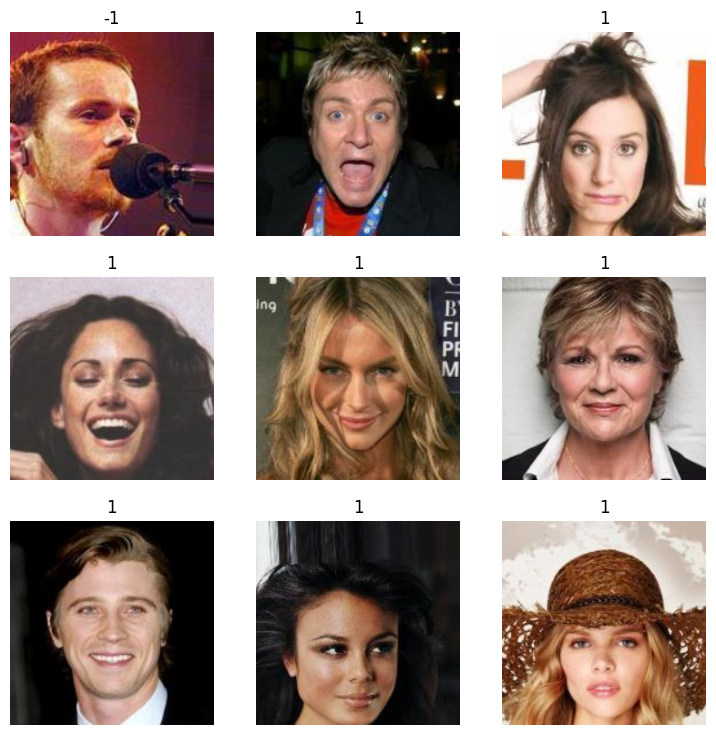

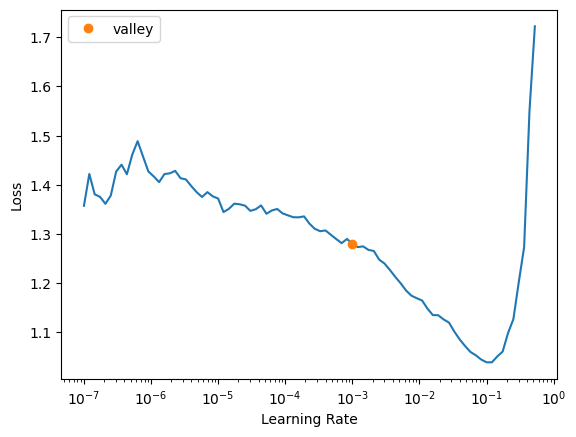

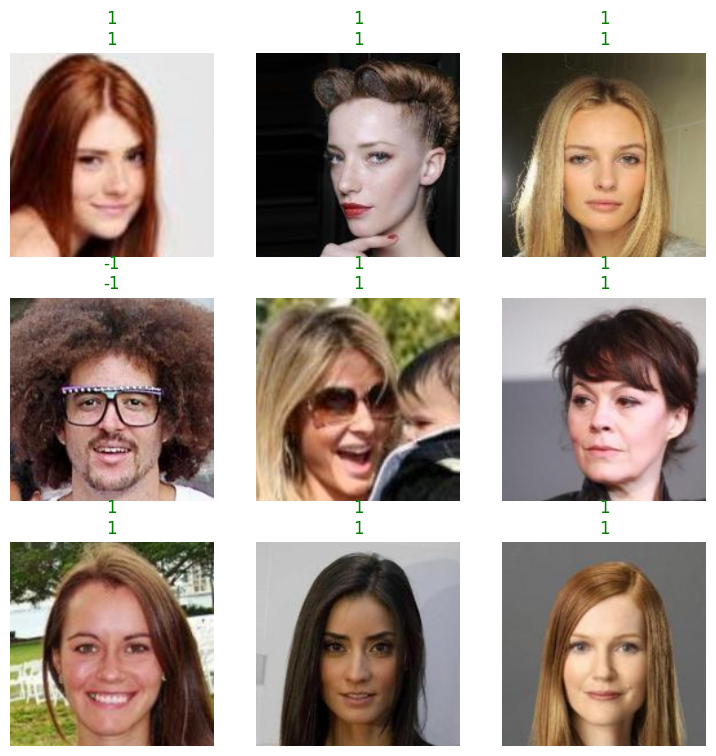

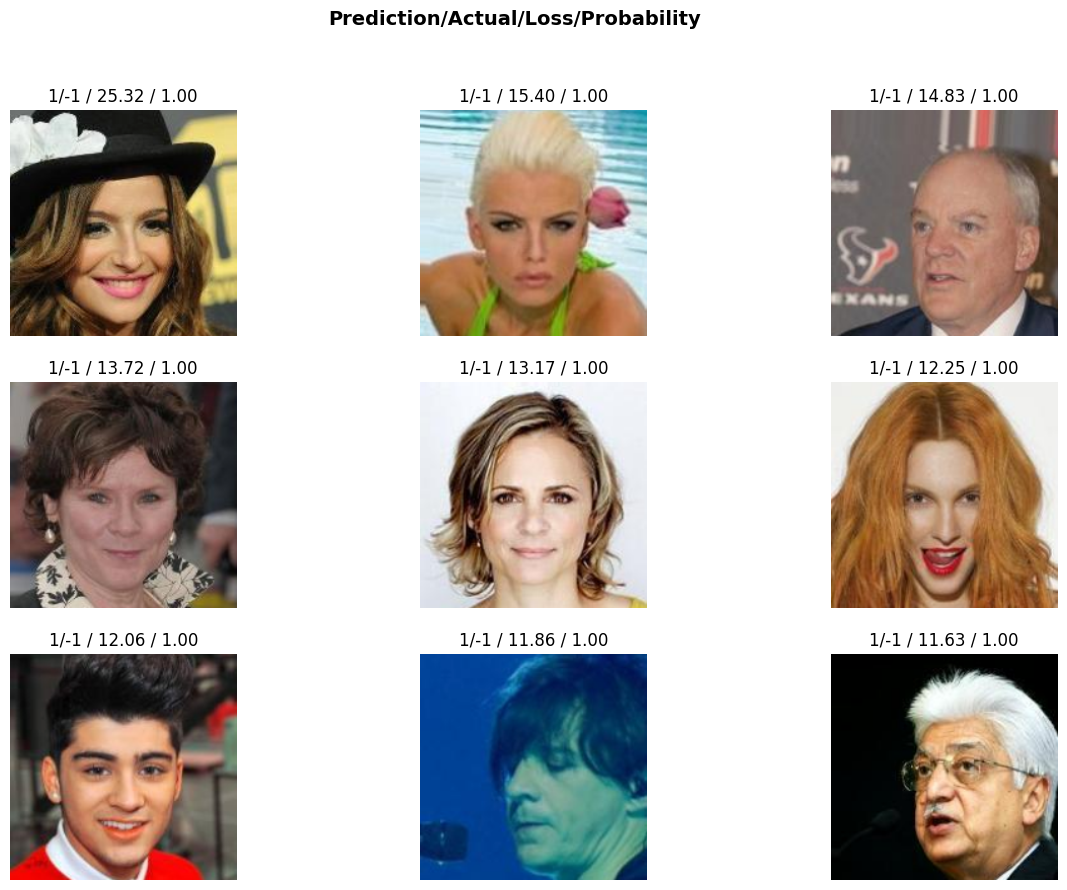

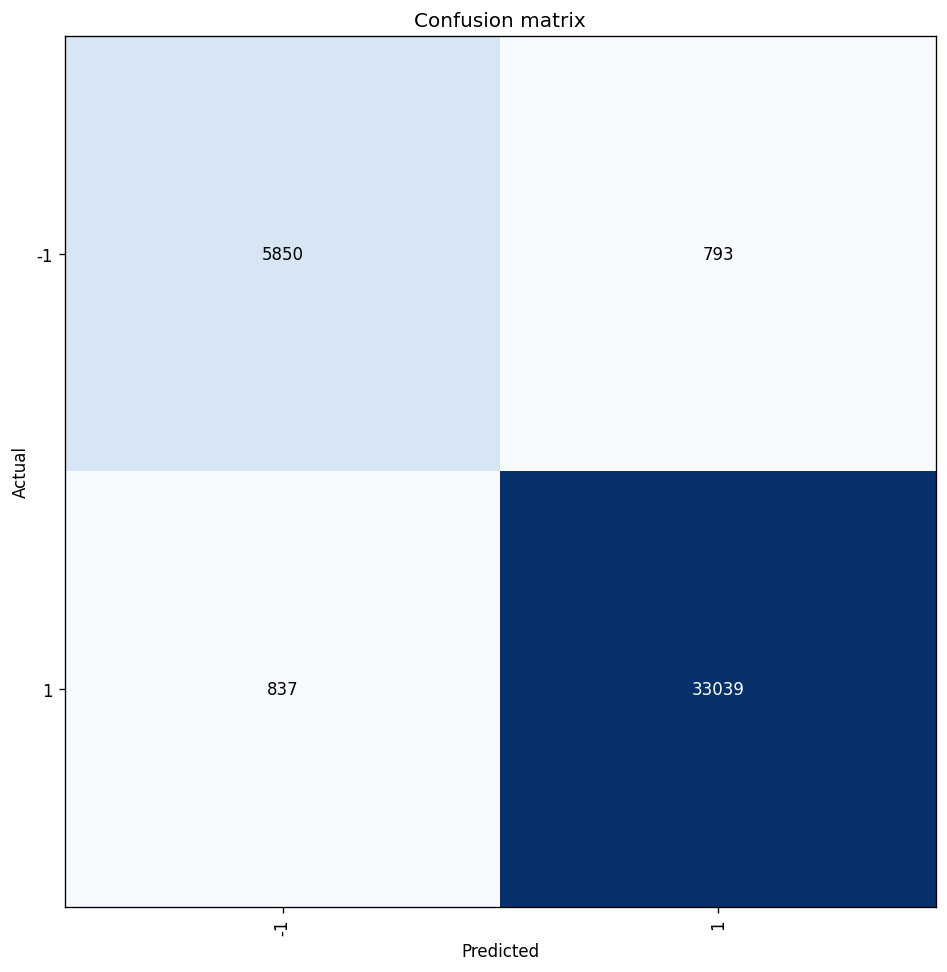

In [ ]:
run(beard_dls)

#### Have Earing

Show Batch
LR Find


Show Results


Show Losses


Show Confusion Matrix


              precision    recall  f1-score   support

          -1       0.95      0.94      0.95     32867
           1       0.77      0.81      0.79      7652

    accuracy                           0.92     40519
   macro avg       0.86      0.88      0.87     40519
weighted avg       0.92      0.92      0.92     40519



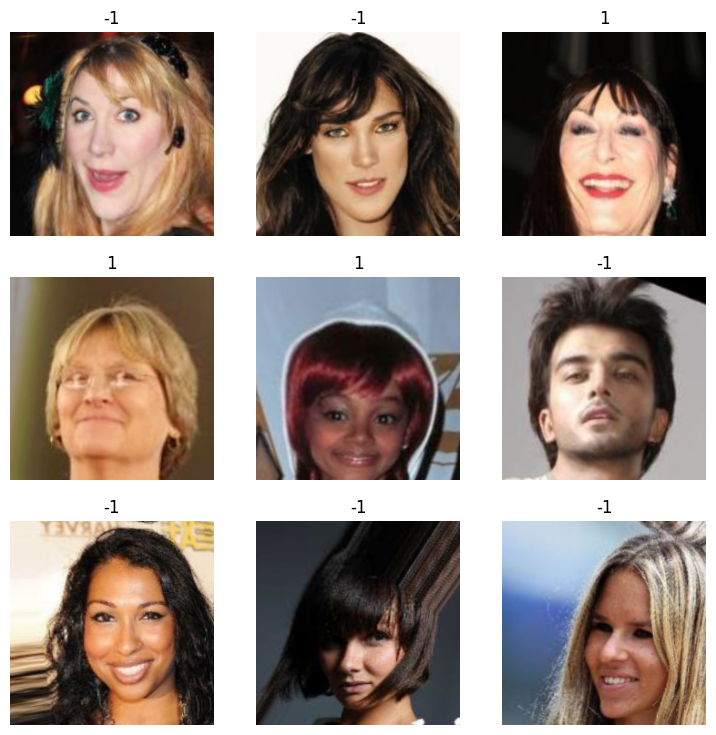

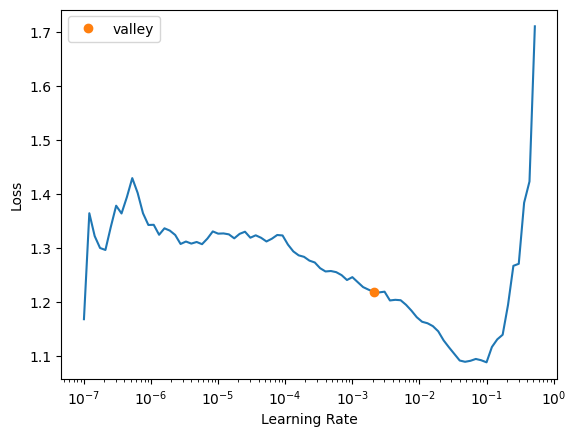

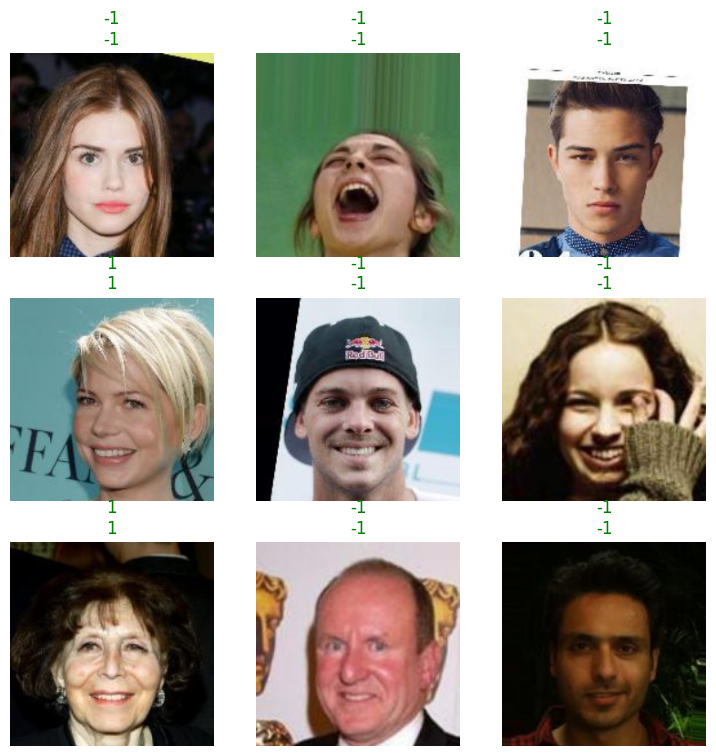

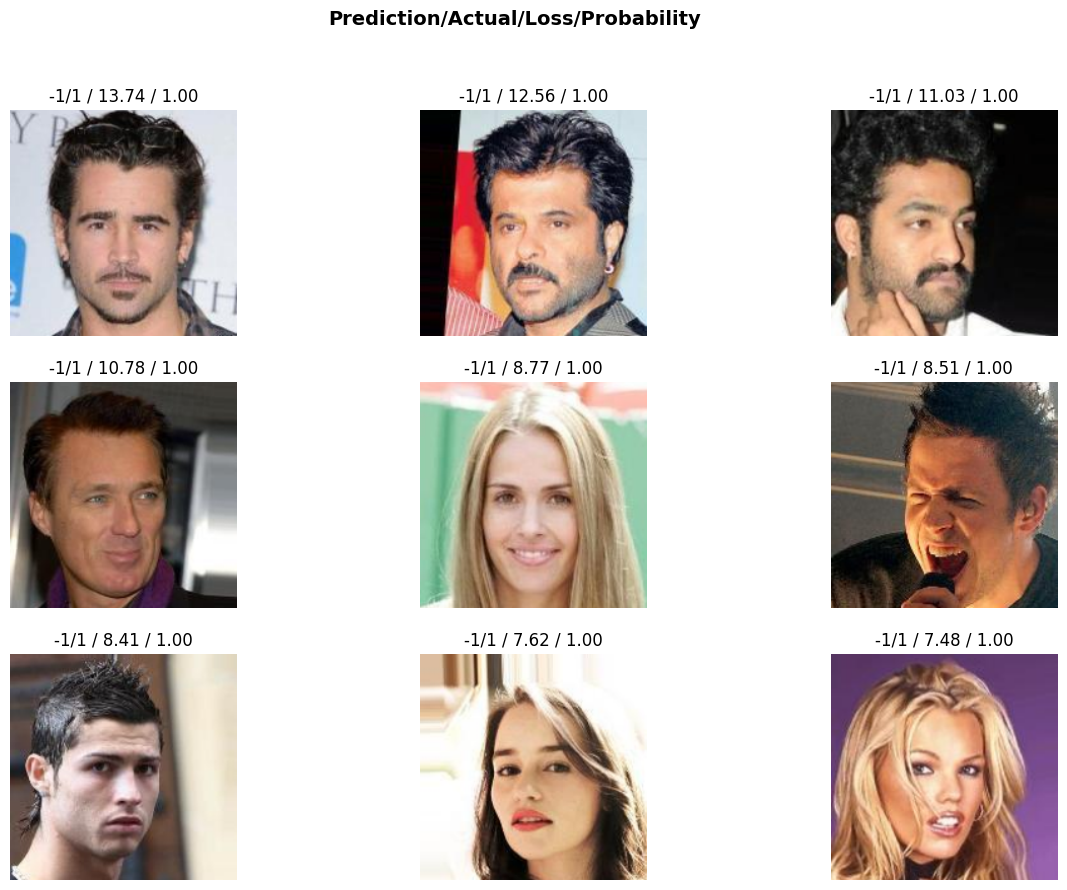

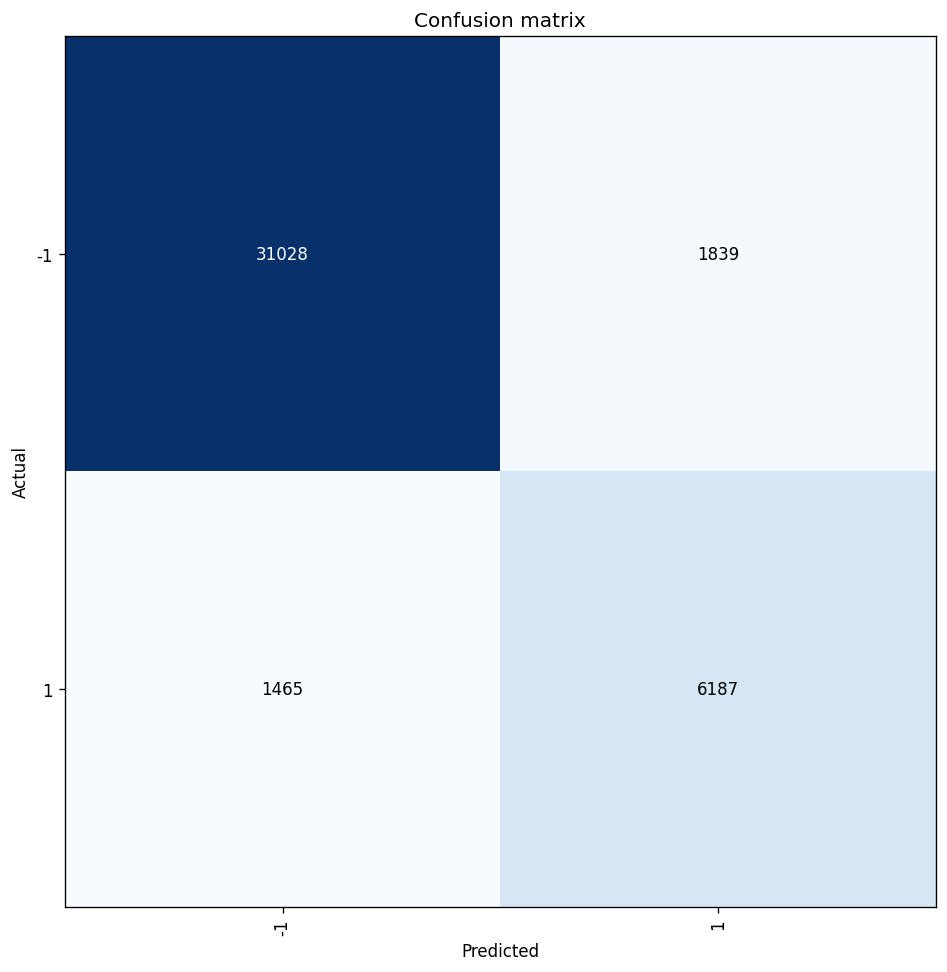

In [ ]:
run(earing_dls)

## Additional Question for Practice

**Question:** Select a collection of connected images. Create a graph of the links among images or objects in images (42pt). Use graph algorithms to discover interesting insights regarding the images. See, for example, [Figure 2](https://arxiv.org/pdf/1509.00568.pdf) (8pt).